<h3  style = "color: skyblue" >Import Libraries<h3>

In [1]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    classification_report, 
    precision_score
)


<h3  style = "color: skyblue" >Data Ingestion and Loading<h3>

In [2]:
data = pd.read_csv("../data/spam.csv", encoding='latin1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<h3 style = "color:skyblue" >Data Overview</h3>

In [3]:
data.shape

(5572, 5)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


<h3 style = "color:skyblue" >Data Cleaning</h3>

In [5]:
#Filtering unnecessary features
data = data.iloc[:,:2]
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
#arranging the columns and renaming them
data = data[["v2", "v1"]]
data = data.rename(columns={'v2':'text', 'v1':'target'})
data.head()

,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [7]:
#converting our target varaible to binary class
data["target"] = np.where(data["target"] == "spam", 1, 0)
data.head()

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [8]:
#check null values
data.isna().sum()

text      0
target    0
dtype: int64

In [9]:
#check duplicated values
duplicated = data.duplicated().sum()

print(f"Duplicated observations: {duplicated}")

Duplicated observations: 403


In [10]:
#dropping duplicated observations 
data = data.drop_duplicates()
data.head()

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [11]:
#rechecking the duplicated after the drop
data.duplicated().sum()

np.int64(0)

In [12]:
data.shape

(5169, 2)

<h3 style = "color:skyblue" >NLP Pipeline</h3>

In [13]:
data["text"]

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5169, dtype: object

In [14]:
# download the spacy model
nlp = spacy.load("en_core_web_sm")

#helper function
def lower_replace(series):
    
    '''
    This function applies:
    1. lowercasing the text
    2. remove puncutations
    3. remove[...] whatever inside the bracket
    4. remove links
     
    '''
    output = series.str.lower()
    output = output.str.replace(r'\[.*?\]', '', regex=True)
    output = output.str.replace(r'[^\w\s]', '', regex=True)   
    output = output.str.replace(r'https?://\S+|www\.\S+', '', regex=True) 
    return output


def token_lemma_nonstop(text):
    doc = nlp(text)
    output = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(output)


#main function that act as a pipeline
def nlp_pipeline(series):
    output = lower_replace(series)
    output = output.apply(token_lemma_nonstop)
    return output

In [15]:
data["text_clean"] = nlp_pipeline(data["text"])
data.head()

,text,target,text_clean
0,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...
1,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,0,u dun early hor u c
4,"Nah I don't think he goes to usf, he lives aro...",0,nah not think go usf live


<h3 style = "color: skyblue">Exploratory Data Analysis</h3>

In [16]:
# Exploring the Target varaible
hamvsspam = (data["target"].value_counts(normalize=True) * 100 ).round(2)
hamvsspam

target
0    87.37
1    12.63
Name: proportion, dtype: float64

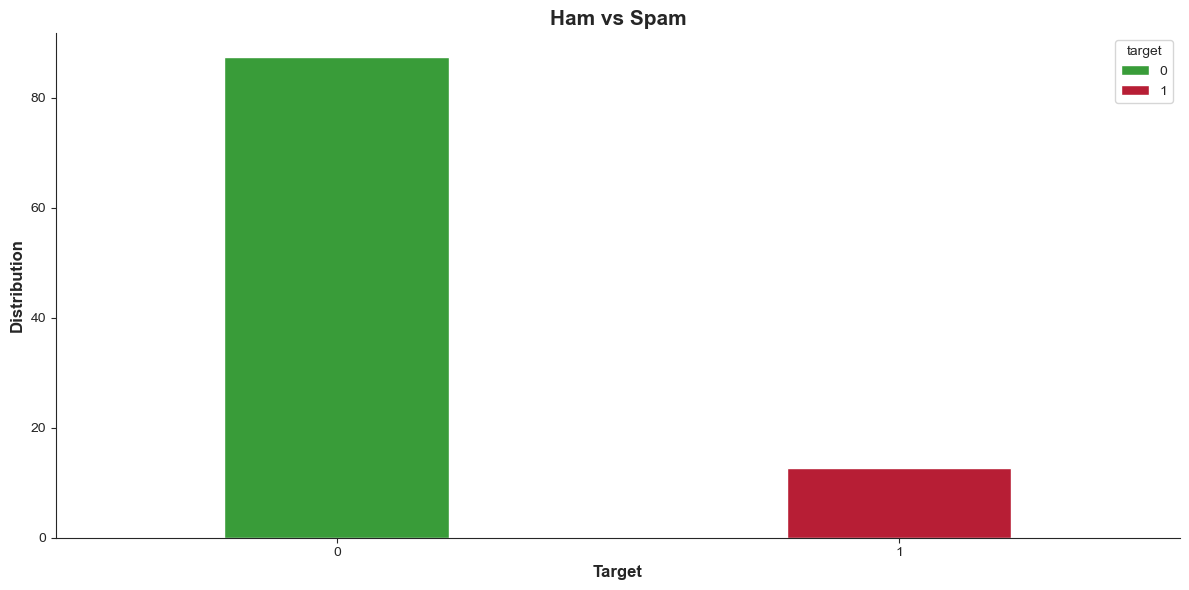

In [17]:
#figure
color_style = ["#29AC29", "#D00523"]
plt.figure(figsize=(12,6))
sns.set_style('ticks')
sns.barplot(x=hamvsspam.index, y=hamvsspam.values, width=.4, palette=color_style, hue=hamvsspam.index)
plt.xlabel('Target', fontsize = 12, fontweight='bold')
plt.ylabel('Distribution', fontsize = 12, fontweight='bold')
plt.title("Ham vs Spam", fontsize= 15, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.show()

The chart shows that the ~ 87% are ham sms, while a small percentage (around 12%) are spam sms.
This indicates that the dataset is imbalanced, We will address it later on.

<h5 style = "color:skyblue">WordCloud:</h5> 

- Visualizes the most frequent words in a text
- bigger words = higher frequency


### FOR SPAM SMS

In [18]:
wc = WordCloud(width=600, height=300, max_words=30, min_font_size=10, background_color='white')

spam_wc = wc.generate(data[data["target"] == 1]["text_clean"].str.cat(sep = ' '))
spam_wc

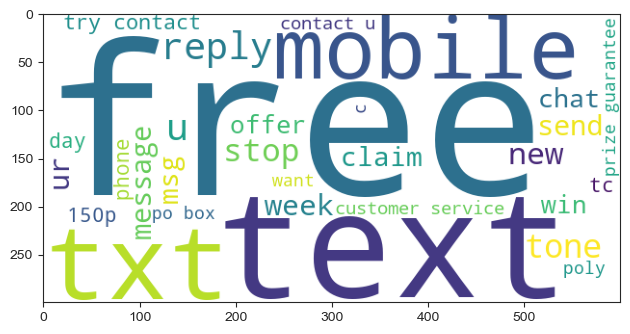

In [19]:
plt.imshow(spam_wc)
plt.tight_layout()
plt.show()

### FOR HAM SMS

In [20]:
wc = WordCloud(width=600, height=300, max_words=30, min_font_size=10, background_color='white')


ham_wc = wc.generate(data[data["target"] == 0]["text_clean"].str.cat(sep = ' '))
ham_wc

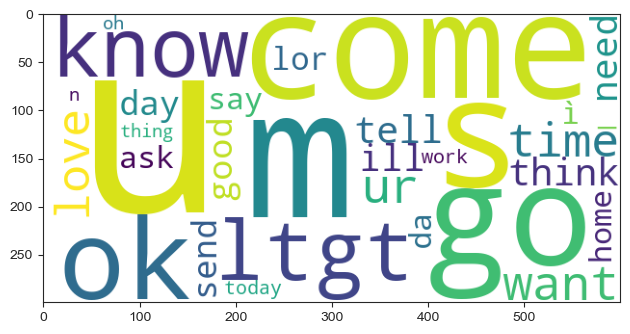

In [21]:
plt.imshow(ham_wc)
plt.tight_layout()
plt.show()

<h3 style = "color:skyblue">Feature Engineering</h3>

We engineer new feature likes -

1. No. of characters in the document
2. No. of words in the document
3. No. of senetences in the document

In [22]:
data = data.copy()
data_v2 = data[["text_clean", "target"]]
data_v2.head()

,text_clean,target
0,jurong point crazy available bugis n great wor...,0
1,ok lar joking wif u oni,0
2,free entry 2 wkly comp win fa cup final tkts 2...,1
3,u dun early hor u c,0
4,nah not think go usf live,0


In [23]:
#num of characters
data_v2["num_characters"] = data_v2["text_clean"].apply(len)
data_v2.head()

,text_clean,target,num_characters
0,jurong point crazy available bugis n great wor...,0,79
1,ok lar joking wif u oni,0,23
2,free entry 2 wkly comp win fa cup final tkts 2...,1,131
3,u dun early hor u c,0,19
4,nah not think go usf live,0,25


In [24]:
#num of words
nlp  = spacy.load('en_core_web_sm')

def count_words(text):
    doc = nlp(text)
    return len([token.text for token in doc if not token.is_punct and not token.is_space])

def count_sentencces(text):
    doc = nlp(text)
    return len(list(doc.sents))

In [25]:
data_v2["num_words"] = data_v2["text_clean"].apply(count_words)
data_v2.head()

,text_clean,target,num_characters,num_words
0,jurong point crazy available bugis n great wor...,0,79,15
1,ok lar joking wif u oni,0,23,6
2,free entry 2 wkly comp win fa cup final tkts 2...,1,131,22
3,u dun early hor u c,0,19,6
4,nah not think go usf live,0,25,6


### Summary Stats: spam sms

In [26]:
data_v2[data_v2["target"] == 1][["num_characters", "num_words"]].describe().T

,count,mean,std,min,25%,50%,75%,max
num_characters,653.0,97.960184,26.257192,12.0,85.0,103.0,116.0,151.0
num_words,653.0,15.479326,4.745190,2.0,13.0,16.0,18.0,27.0


### Summary Stats: ham sms

In [27]:
data_v2[data_v2["target"] == 0][["num_characters", "num_words"]].describe().T

,count,mean,std,min,25%,50%,75%,max
num_characters,4516.0,38.382861,32.317586,0.0,18.0,29.0,50.0,456.0
num_words,4516.0,7.314438,5.744958,0.0,4.0,6.0,9.0,73.0


We can clearly see that the average number of characters and words of spam sms are quite higher compared to ham sms

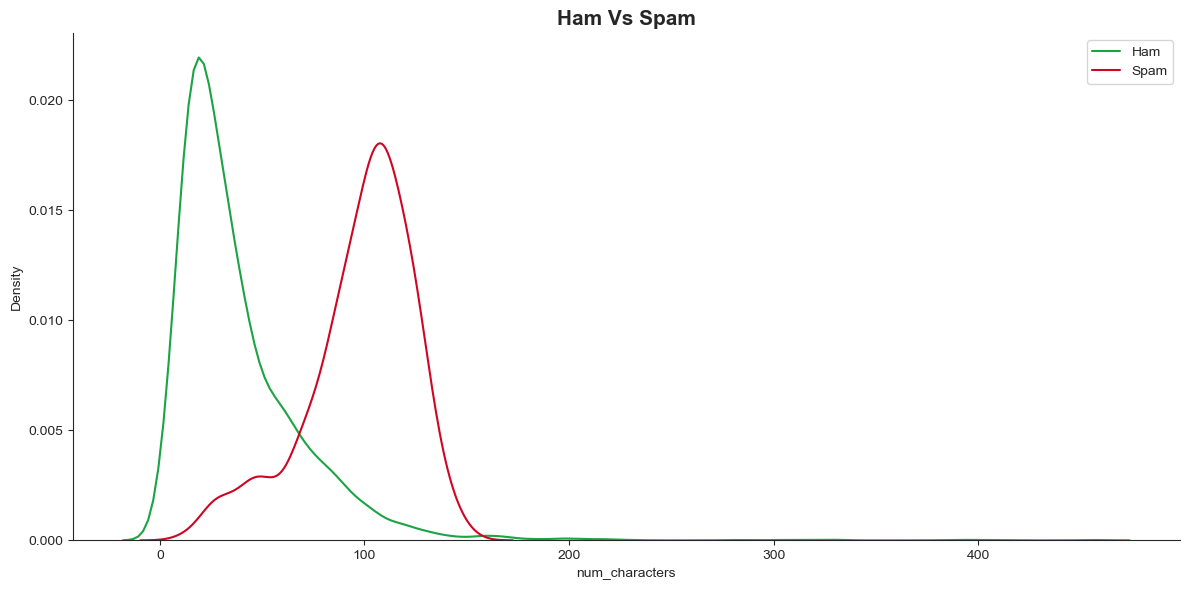

In [28]:
#visualizing the number of characters for ham and spam
plt.figure(figsize=(12,6))
sns.set_style('ticks')
sns.kdeplot(data_v2[data_v2["target"] == 0]["num_characters"], label = "Ham", color="#1BA344")
sns.kdeplot(data_v2[data_v2["target"] == 1]["num_characters"], label = "Spam", color="#D00523")
plt.title("Ham Vs Spam", fontsize = 15, fontweight = 'bold')
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

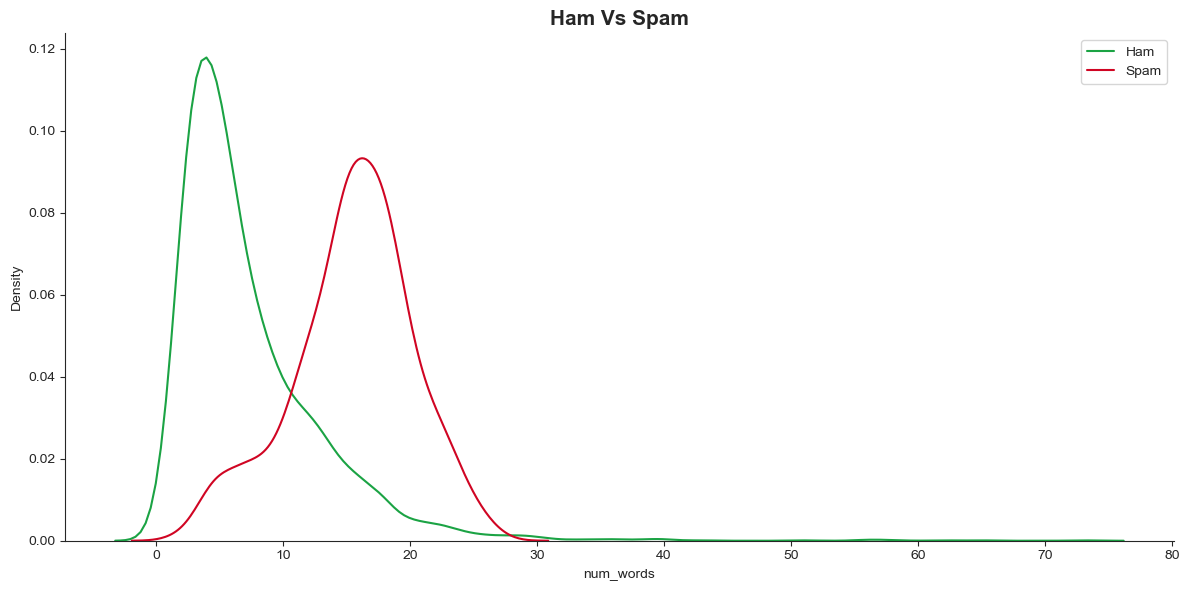

In [29]:
#visualizing the number of words for ham and spam
plt.figure(figsize=(12,6))
sns.set_style('ticks')
sns.kdeplot(data_v2[data_v2["target"] == 0]["num_words"], label = "Ham", color="#1BA344")
sns.kdeplot(data_v2[data_v2["target"] == 1]["num_words"], label = "Spam", color="#D00523")
plt.title("Ham Vs Spam", fontsize = 15, fontweight = 'bold')
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

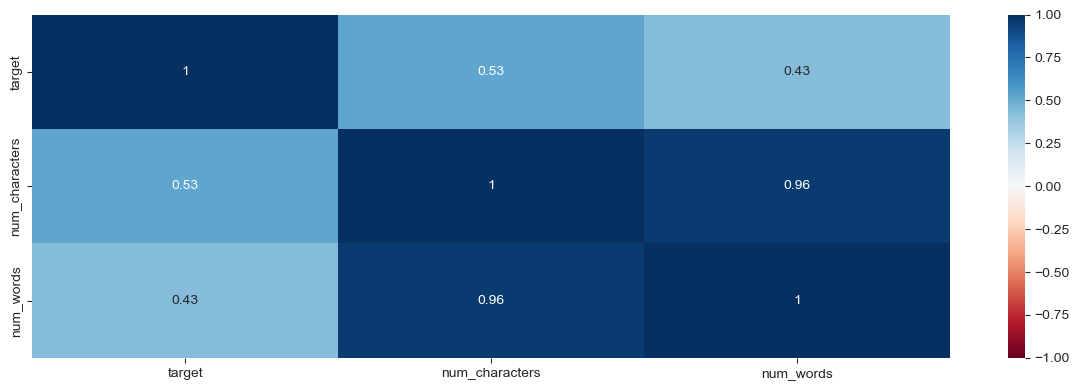

In [30]:
#checking the correlations 
corr = data_v2.corr(numeric_only=True)

plt.figure(figsize=(12,4))
sns.heatmap(corr, annot=True, vmin= -1, vmax=1, cmap= "RdBu")
plt.tight_layout()
plt.show()

As we see `multicollinearity` here, we cannot use all the features we created, instead we shall only use one feature and that should be num_characters since it has high correlation with the target varaible

<h3 style="color:skyblue">Vectorized</h3>

#### Bag of words

In [31]:
cv = CountVectorizer(stop_words='english', min_df=5)
X_cv = cv.fit_transform(data_v2["text_clean"])
Xcv_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names_out())
Xcv_df.head()

,0800,08000839402,08000930705,0870,08712300220,08712460324,08718720201,10,100,1000,...,å200,å2000,å250,å350,å500,å5000,å800,å900,ìï,ûò
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### TF-IDF

In [32]:
tv = TfidfVectorizer(stop_words="english", min_df=5)
X_tfidf = tv.fit_transform(data["text_clean"])
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tv.get_feature_names_out())
X_tfidf_df.head()

,0800,08000839402,08000930705,0870,08712300220,08712460324,08718720201,10,100,1000,...,å200,å2000,å250,å350,å500,å5000,å800,å900,ìï,ûò
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
y = data_v2["target"]
y.head()

0    0
1    0
2    1
3    0
4    0
Name: target, dtype: int64

<h3 style = "color:skyblue">Model Training</h3>

In [34]:
data_v2.head()

,text_clean,target,num_characters,num_words
0,jurong point crazy available bugis n great wor...,0,79,15
1,ok lar joking wif u oni,0,23,6
2,free entry 2 wkly comp win fa cup final tkts 2...,1,131,22
3,u dun early hor u c,0,19,6
4,nah not think go usf live,0,25,6


In [35]:
#splitting the data into train set and testing set for the evaluation
#using tfidf vectorized method
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_df, y, test_size=0.2, random_state=42)

In [36]:
#MODEL -1

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [37]:
y_pred = lr.predict(X_test)
print(f"Acurracy score: {accuracy_score(y_test, y_pred)}\n")
print(f"Precision score: {precision_score(y_test, y_pred)}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Acurracy score: 0.9584139264990329

Precision score: 0.9811320754716981

Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       889
           1       0.98      0.72      0.83       145

    accuracy                           0.96      1034
   macro avg       0.97      0.86      0.90      1034
weighted avg       0.96      0.96      0.96      1034



In [38]:
#MODEL -2

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [39]:
y_pred = nb.predict(X_test)
print(f"Acurracy score: {accuracy_score(y_test, y_pred)}\n")
print(f"Precision score: {precision_score(y_test, y_pred)}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Acurracy score: 0.9748549323017408

Precision score: 0.9917355371900827

Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       889
           1       0.99      0.83      0.90       145

    accuracy                           0.97      1034
   macro avg       0.98      0.91      0.94      1034
weighted avg       0.98      0.97      0.97      1034



<h3 style = "color:skyblue">Pickling model</h3>

In [40]:
import pickle
import gzip

#save with gzip compression
with gzip.open('../artifacts/vectorizer.pkl.gz', 'wb') as f:
    pickle.dump(tv, f)

with gzip.open('../artifacts/model.pkl.gz', 'wb') as f:
    pickle.dump(nb, f)